In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# NBA season we will be analyzing
year = 2021
# URL page we will scraping (see image above)
url = "https://www.basketball-reference.com/leagues/NBA_2021_totals.html".format(year)
# this is the HTML from the given URL
html = urlopen(url)
soup = BeautifulSoup(html)

In [3]:
# use findALL() to get the column headers
soup.findAll('tr', limit=2)
# use getText()to extract the text we need into a list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
# exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
headers = headers[1:]

In [4]:
# avoid the first header row
rows = soup.findAll('tr')[1:]
player_stats = [[td.getText() for td in rows[i].findAll('td')]
            for i in range(len(rows))]

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow.keras as kb
from tensorflow.keras import backend
import tensorflow as tf
from plotnine import *
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as sch

from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix


In [6]:
stats = pd.DataFrame(player_stats, columns = headers)
stats.to_csv('nba_2021_data_total.csv', header = True)

In [7]:
stats.shape
stats.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,PF,21,MIA,61,4,737,124,228,.544,...,.509,73,135,208,29,20,28,43,91,304
1,Jaylen Adams,PG,24,MIL,7,0,18,1,8,.125,...,,0,3,3,2,0,0,0,1,2
2,Steven Adams,C,27,NOP,58,58,1605,189,308,.614,...,.444,213,301,514,111,54,38,78,113,438
3,Bam Adebayo,C,23,MIA,64,64,2143,456,800,.570,...,.799,142,431,573,346,75,66,169,145,1197
4,LaMarcus Aldridge,C,35,TOT,26,23,674,140,296,.473,...,.872,19,99,118,49,11,29,27,47,352


In [8]:
stats.drop(stats.index[stats['FG%'] == ''], inplace=True)
stats.drop(stats.index[stats['FT%'] == ''], inplace=True)
stats.drop(stats.index[stats['3P%'] == ''], inplace=True)
stats.drop(stats.index[stats['2P%'] == ''], inplace=True)
stats.drop(stats.index[stats['eFG%'] == ''], inplace=True)

stats.dropna(inplace=True)
stats.reset_index(inplace=True)

In [9]:
stats = stats.astype({'Age':'float','G':'float', 'GS':'float', 'MP':'float', 'FG':'float', 'FGA':'float', 'FG%':'float', '3P':'float',
       '3PA':'float', '3P%':'float', '2P':'float', '2PA':'float', '2P%':'float', 'eFG%':'float', 'FT':'float', 'FTA':'float', 'FT%':'float', 'ORB':'float',
       'DRB':'float', 'TRB':'float', 'AST':'float', 'STL':'float', 'BLK':'float', 'TOV':'float', 'PF':'float', 'PTS':'float'})

# Question 1) 

When considering points, blocks, minutes played, and 3-points, what types of clusters emerge and what characterizes these clusters?

HAC Silhouette Score:  0.49490223311932474 



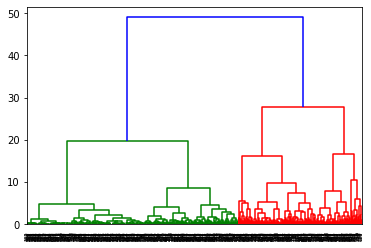

In [10]:
predictors_q1 = ["PTS", "BLK", "MP", "3P"]
X_q1 = stats[predictors_q1]

#z-score
z = StandardScaler()
X_q1 = z.fit_transform(X_q1)

# model
hac = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward")
hac.fit(X_q1)
dendro = sch.dendrogram(sch.linkage(X_q1, method='ward'))

membership = hac.labels_
score_hac = silhouette_score(X_q1,membership)

stats["cluster_hac"] = membership

print("HAC Silhouette Score: ",score_hac, "\n")

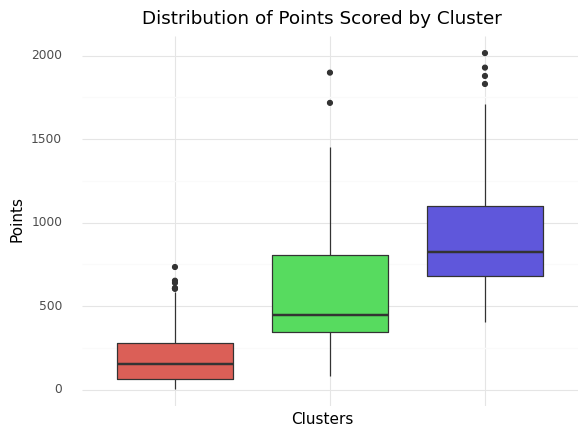

<ggplot: (8778768491741)>

In [11]:
(ggplot(stats, aes(x = "factor(cluster_hac)", y = "PTS")) + geom_boxplot(aes(fill = "factor(cluster_hac)")) + theme_minimal() + 
 labs(x = "Clusters", y = "Points") + ggtitle("Distribution of Points Scored by Cluster") +
 theme(legend_position = 'none',
       axis_text_x = element_blank()))

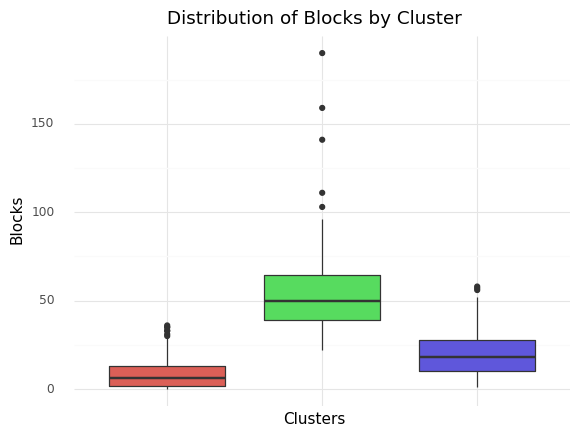

<ggplot: (8778620587697)>

In [12]:
(ggplot(stats, aes(x = "factor(cluster_hac)", y = "BLK")) + geom_boxplot(aes(fill = "factor(cluster_hac)")) + theme_minimal() + 
 labs(x = "Clusters", y = "Blocks") + ggtitle("Distribution of Blocks by Cluster") +
 theme(legend_position = 'none',
       axis_text_x = element_blank()))

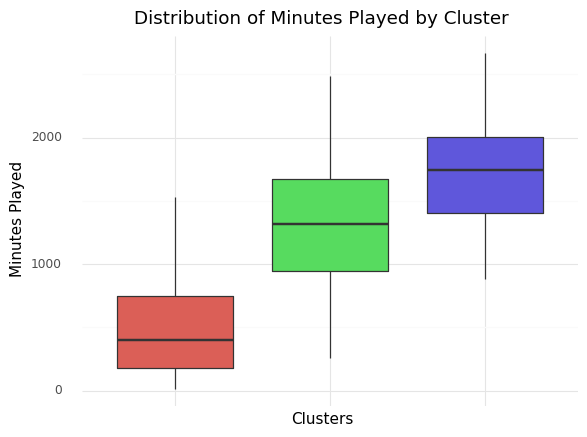

<ggplot: (8778620573673)>

In [13]:
(ggplot(stats, aes(x = "factor(cluster_hac)", y = "MP")) + geom_boxplot(aes(fill = "factor(cluster_hac)")) + theme_minimal() +
 labs(x = "Clusters", y = "Minutes Played") + ggtitle("Distribution of Minutes Played by Cluster") +
 theme(legend_position = 'none',
       axis_text_x = element_blank()))

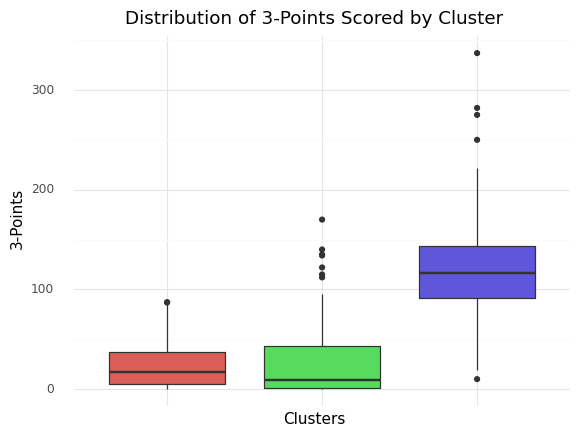

<ggplot: (8778765853013)>

In [14]:
(ggplot(stats, aes(x = "factor(cluster_hac)", y = "3P")) + geom_boxplot(aes(fill = "factor(cluster_hac)")) + theme_minimal() +
 labs(x = "Clusters", y = "3-Points") + ggtitle("Distribution of 3-Points Scored by Cluster") +
 theme(legend_position = 'none',
       axis_text_x = element_blank()))

## Question 1 Answer

After building the model, the data was divided into 3 clusters. By looking at the boxplots and distributions of each predictor by cluster we are able to determine what may characterize each group. 

The first box plot on the left, or red cluster seems to have low totals on all four features. This group is likely to be players who do not play that much, like bench players or players who got injured during the season, as they did not have as much playing time compared to the rest of the groups. This would make sense why their other playing stats like scoring and blocks would be low as well as they are getting very little playing time. 

The middle box plot, or green cluster, are likely to be players who still make an impact on the game but are not the star players and shooters on the team. This group of players are still getting a decent amount of playing time and scoring points throughout the season. Although they are not the highest on scoring and playing minutes, they do have the most blocks compared to the other clusters. Since they have a lot of blocks and are very low on 3-pointers, this can indicate that these are probably players that are taller and players who may be centers or power forwards as they have the reach for blocking shots and are still scoring a decent amount of points, but not long distance. This group of players are still making a huge impact on the game, especially defensively, as they are not long-distance shooters, but they are still scoring points and blocking lots of shots. 

The last cluter, or box plot on the right (blue cluster) seems to have the highest stats on all of the features in the model EXCEPT for blocks. This cluster are the star players of the team as these players get the most amount of playing time compared to the other two groups. Additionally, this group consists of more offensive-type players who shoot long distance as they score a lot of 3-points and have the highest total points for the season.



# Question 2)

How well does our model perform when classifying whether someone is a Center based on blocks, rebounds, steals, 3-point shots, and minutes played?

In [15]:
dummies = pd.get_dummies(stats, columns = ["Pos"])


In [16]:
predictors_q2 = ["BLK", "TRB", "STL", "3P", "MP"]

#TTS and Standardization
X2_train, X2_test, y2_train, y2_test = train_test_split(dummies[predictors_q2], dummies["Pos_C"], test_size=0.2, random_state = 11)

z = StandardScaler()
z.fit(X2_train)

X2_train = z.transform(X2_train)
X2_test = z.transform(X2_test)

#model
logR = LogisticRegression()
logR.fit(X2_train, y2_train)

#predictions - train set
pred_train = logR.predict(X2_train)
acc_train = accuracy_score(y2_train, pred_train)

#predictions - test set
pred_test = logR.predict(X2_test)
acc_test = accuracy_score(y2_test, pred_test)

print("Train Accuracy Score: ", acc_train)
print("Test Accuracy Score: ", acc_test)

Train Accuracy Score:  0.9129593810444874
Test Accuracy Score:  0.9307692307692308


Text(0.5, 1.0, 'Test Set Confusion Matrix')

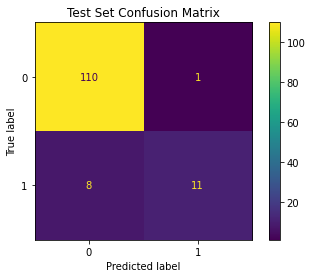

In [17]:
plot_confusion_matrix(logR,X2_test, y2_test)
plt.title('Test Set Confusion Matrix')

Text(0.5, 1.0, 'Train Set Confusion Matrix')

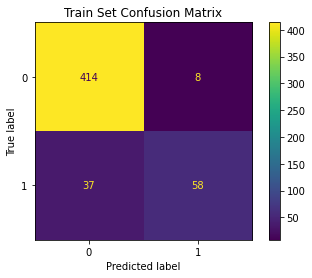

In [18]:
plot_confusion_matrix(logR,X2_train, y2_train)
plt.title('Train Set Confusion Matrix')

In [19]:
t_v_p = pd.DataFrame({"True": y2_test, "Predicted": pred_test})

true_not_center = len(t_v_p.loc[t_v_p["True"] == 0])
true_center = len(t_v_p.loc[t_v_p["True"] == 1])

pred_not_center = len(t_v_p.loc[t_v_p["Predicted"] == 0])
pred_center = len(t_v_p.loc[t_v_p["Predicted"] == 1])

center = pd.DataFrame({"Info": ["Not Center", " Centers", "Predicted Non-Center", " Predicted Centers"], "Value": [true_not_center, true_center, pred_not_center, pred_center]})


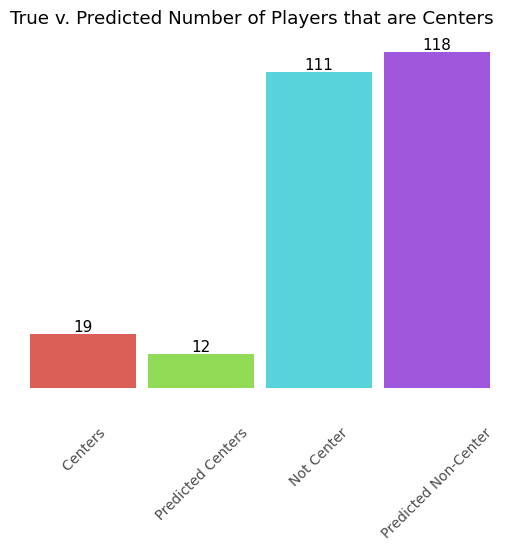

<ggplot: (8778620387729)>

In [20]:
from numpy.ma.core import sort
(ggplot(center, aes(x = "Info", y = "Value", fill = "Info")) + geom_bar(stat = "identity") +
 theme_minimal() + labs(title = "True v. Predicted Number of Players that are Centers", x = "", y = "") + 
 theme(axis_text_x = element_text(angle=45), legend_position = "none") + 
 geom_text(label = [true_not_center, true_center, pred_not_center, pred_center], vjust = "bottom") + 
 theme(panel_grid_minor_x = element_blank(),
       panel_grid_major_x = element_blank(),
       panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank(),
       axis_text_y = element_blank(),
       axis_text_x = element_text(size = 10)))

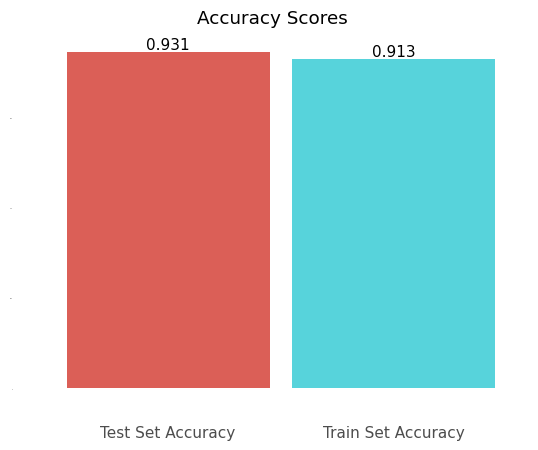

<ggplot: (8778620390301)>

In [21]:
accuracies = [acc_train, acc_test]

accuracy = pd.DataFrame({"Accuracy Scores": accuracies, "Title": ["Train Set Accuracy", "Test Set Accuracy"]})

(ggplot(accuracy, aes(x = "Title", y = "Accuracy Scores", fill = "Title")) +
geom_bar(stat = "identity") + theme_minimal() + labs(x = "", y = "") +
ggtitle("Accuracy Scores") +
geom_text(label = [round(acc_train,3), round(acc_test,3)], vjust = "bottom") +
theme(legend_position = "none",
       axis_text_x = element_text(size = 11),
       axis_title_x = element_text(size = 12),
       axis_text_y = element_text(size = 0),
       panel_grid_minor_x = element_blank(),
       panel_grid_major_x = element_blank(),
       panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()))

In [22]:
#coefficients in regression model
coef = pd.DataFrame({"Coefs": logR.coef_[0],
                    "Variables": predictors_q2})

coef["Odds Coefs"] = np.exp(coef["Coefs"])

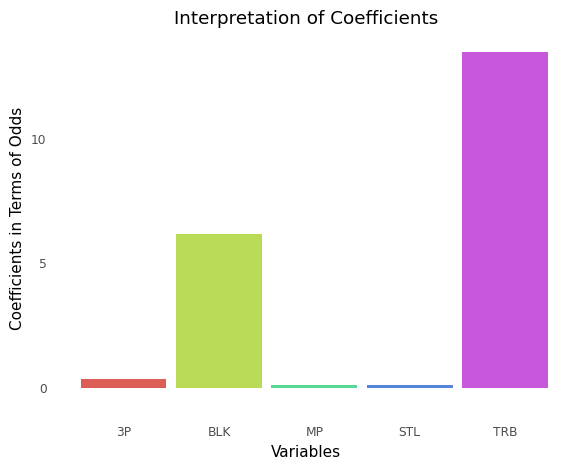

<ggplot: (8778620360689)>

In [23]:
(ggplot(coef, aes(x = "Variables", y = "Odds Coefs", fill = "Variables")) + geom_bar(stat = "identity") + theme_minimal() + 
 theme(panel_grid_minor_x = element_blank(),
       panel_grid_major_x = element_blank(),
       panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank(),
       legend_position = "none") + 
 ggtitle("Interpretation of Coefficients") + labs(y = "Coefficients in Terms of Odds"))

## Question 2 Answer

Our model performs well when classifying whether someone is a center based on 3-points, blocks, minutes played, steals, and total rebounds. Looking at our model, our accuracy of the model is pretty high as our model was 92% accurate on data that it has not seen before. Also, our model is not overfit as the accuracy score was higher for the test set as the accuracy score for the training set was around 91%. Additionally, looking at the True versus Predicted numbers we can see that only seven players were missclassified as not playing in the center position meaning that our model performed fairly well and can determine whether someone plays in a certain position.

# Question 3)

When comparing a model using LASSO on all continuous variables to a model on all continuous variables to predict total number of points scored, how does each model perform, and which model would you choose? Why are these the results?

In [24]:
features = ['Age','G', 'GS', 'MP', 'FG%','eFG%', 'ORB',
        'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

X3_train, X3_test, y3_train, y3_test = train_test_split(stats[features], stats["PTS"], test_size=0.2, random_state = 42)

z = StandardScaler()
z.fit(X3_train)

X3_train = z.transform(X3_train)
X3_test = z.transform(X3_test)

lr = LinearRegression()
lr.fit(X3_train, y3_train)

#predictions for train set
y_pred_train = lr.predict(X3_train)

#predictions for test set
y_pred_test = lr.predict(X3_test)

#r2 scores - test and train set
r2_train = lr.score(X3_train, y3_train)
r2_test = lr.score(X3_test, y3_test)

print("R2 Score - Train Set: ", r2_train)
print("R2 Score - Test Set: ", r2_test)

print()
#mean absolute error - test and train set
mae_train = mean_absolute_error(y3_train, y_pred_train)
mae_test = mean_absolute_error(y3_test, y_pred_test)

print("Mean Absolute Error - Train Set: ", mae_train)
print("Mean Absolute Error - Test Set: ", mae_test)

R2 Score - Train Set:  0.9113235226382719
R2 Score - Test Set:  0.9240172533472805

Mean Absolute Error - Train Set:  77.53916069535036
Mean Absolute Error - Test Set:  74.47505209632493


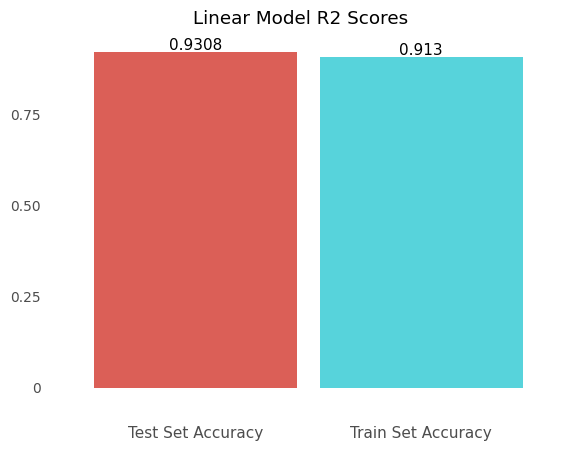

<ggplot: (8778620284393)>

In [25]:
true_vs_pred = pd.DataFrame({"predicted": y_pred_test, "true": y3_test})

accuracies_linear = [r2_train, r2_test]

accuracy_linear = pd.DataFrame({"Accuracy Scores": accuracies_linear, "Title": ["Train Set Accuracy", "Test Set Accuracy"]})

(ggplot(accuracy_linear, aes(x = "Title", y = "Accuracy Scores", fill = "Title")) +
geom_bar(stat = "identity") + theme_minimal() + labs(x = "", y = "") +
ggtitle("Linear Model R2 Scores") +
geom_text(label = [round(acc_train,4), round(acc_test,4)], vjust = "bottom") +
theme(legend_position = "none",
       axis_text_x = element_text(size = 11),
       axis_title_x = element_text(size = 12),
       axis_text_y = element_text(size = 10),
       panel_grid_minor_x = element_blank(),
       panel_grid_major_x = element_blank(),
       panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()))

In [26]:

lsr = Lasso()

lsr.fit(X3_train,y3_train)

lsr_train_score = lsr.score(X3_train, y3_train)
lsr_test_score = lsr.score(X3_test, y3_test)

print("TRAIN MAE: ", mean_absolute_error(y3_train, lsr.predict(X3_train)))
print("TEST MAE: ", mean_absolute_error(y3_test, lsr.predict(X3_test)))
print("")
print("Train Accuracy: ", lsr_train_score)
print("Test Accuracy: ", lsr_test_score)

TRAIN MAE:  76.78504050557447
TEST MAE:  73.1815192571392

Train Accuracy:  0.9104467936946353
Test Accuracy:  0.9212586616664538


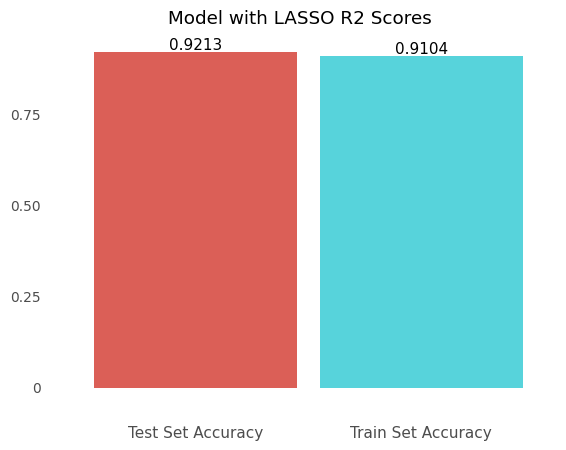

<ggplot: (8778620288273)>

In [27]:
accuracies_lasso = [lsr_train_score, lsr_test_score]

accuracy_lasso = pd.DataFrame({"Accuracy Scores": accuracies_lasso, "Title": ["Train Set Accuracy", "Test Set Accuracy"]})

(ggplot(accuracy_lasso, aes(x = "Title", y = "Accuracy Scores", fill = "Title")) +
geom_bar(stat = "identity") + theme_minimal() + labs(x = "", y = "") +
ggtitle("Model with LASSO R2 Scores") +
geom_text(label = [round(lsr_train_score,4), round(lsr_test_score,4)], vjust = "bottom") +
theme(legend_position = "none",
       axis_text_x = element_text(size = 11),
       axis_title_x = element_text(size = 12),
       axis_text_y = element_text(size = 10),
       panel_grid_minor_x = element_blank(),
       panel_grid_major_x = element_blank(),
       panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()))

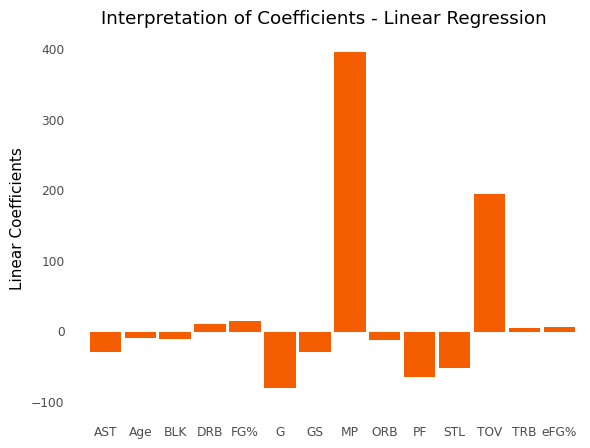

<ggplot: (8778620287033)>

In [28]:
coef = pd.DataFrame({"LASSO Coef": lsr.coef_, "Linear Coef": lr.coef_, "Number": [1,2,3,4,5,6,7,8,9,10,11,12,13,14], "Variable": ['Age','G', 'GS', 'MP', 'FG%','eFG%', 'ORB',
        'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']})


(ggplot(coef, aes(x = "Variable", y = "Linear Coef", fill = "Variable")) + geom_bar(stat = "identity", fill = "#F55E00") + theme_minimal() + 
 theme(panel_grid_minor_x = element_blank(),
       panel_grid_major_x = element_blank(),
       panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()) +
 labs(x = "", y = "Linear Coefficients") + ggtitle("Interpretation of Coefficients - Linear Regression"))

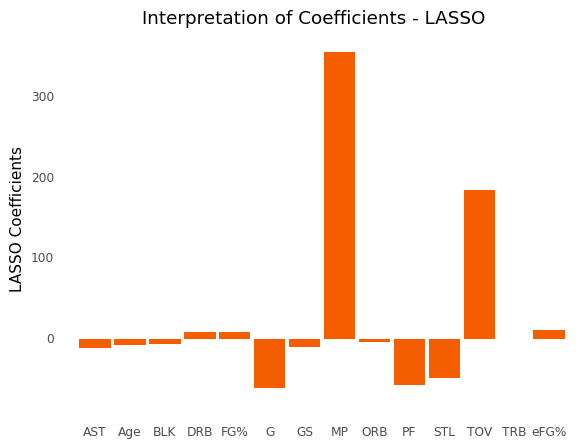

<ggplot: (8778620287097)>

In [29]:
(ggplot(coef, aes(x = "Variable", y = "LASSO Coef")) + geom_bar(stat = "identity", fill = "#F55E00") + theme_minimal() +
 theme(panel_grid_minor_x = element_blank(),
       panel_grid_major_x = element_blank(),
       panel_grid_major_y = element_blank(),
       panel_grid_minor_y = element_blank()) + 
 labs(x = "", y = "LASSO Coefficients") + ggtitle("Interpretation of Coefficients - LASSO"))

## Question 3 Answer

When predicting total number of points scored in a season, the linear regression model had an R2 score of about 93.1% for the test set and an R2 score of about 91.3% for the training set. This demonstrates that the linear regression model does pretty well when predicting total points scored as the R2 score is very high and the model is not overfit as the model performed better on the test, unseen data, than the data that it was trained on. The model using LASSO had an R2 score for the test set of about 92.1% and an R2 score of about 91% for the training set. This shows that the model using LASSO also performs pretty well as the performance of the model is only 1% less than the model without regularization as it is a means of generalizing the model. This model is also not overfit as LASSO is used as a method to generalize the model by making the model less specific towards that data that it was trained on so it can be generalized and applied to future data. 

Looking at the impact of the coefficients for each model, it seems that when using LASSO the only variable that was completely shrinked was total rebounds as the bar graph shows that all other variables still have an impact on the model.

Since there were few changes in the accuracy scores and the interpretation of the coefficients were fairly similar, I would use the linear regression model with no regularization as using LASSO did not generalize our model as much. Additionally, the linear regression model is not overfit and since using LASSO is a way to prevent overfitting, I do not think that we need to use LASSO in our model. 